# Toy model for network curvature

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import networkx as nx
from GraphRicciCurvature.OllivierRicci import OllivierRicci
from GraphRicciCurvature.FormanRicci import FormanRicci
import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)
plt.style.use('paperplot.mplstyle')

Create a random graph using stochasic block modeling with four communities:

In [2]:
sizes = [25, 25, 25, 30]
probs = [[0.7, 0.02, 0.02, 0.03], 
         [0.02, 0.5, 0.02, 0.01], 
         [0.02, 0.02, 0.5, 0.02],
         [0.03, 0.01, 0.02, 0.7]]
G_sbm = nx.stochastic_block_model(sizes, probs, seed=0)
G_sbm.remove_edges_from(nx.selfloop_edges(G_sbm))

Plot graph in spring layout:

/home/jakob/Software/anaconda3/envs/climenv/lib/python3.8/site-packages/IPython/core/pylabtools.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


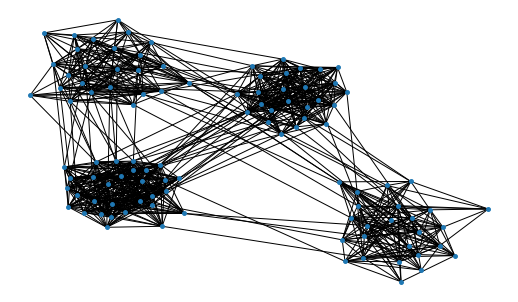

In [3]:
my_pos = nx.spring_layout(G_sbm, seed = 32)
nx.draw(G_sbm, my_pos, node_size=15)

##  Create AR1 time-series with correlation given by Adjacency

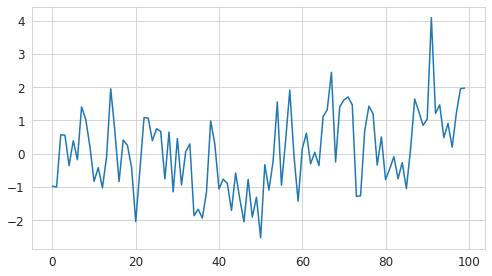

In [4]:
def random_ar_coefficients(order=1):
    """Randomly generate coefficients such that root of all coeffs is smaller 1.
    
    Args:
        order (int): Order of AR Process which is equal to number of coefficients.
            Default is 1. 

    Returns:
        coeffs (list): List of coefficients
    
    """
    filter_stable = False
    # Keep generating coefficients until we come across a set of coefficients
    # that correspond to stable poles
    while not filter_stable:
        true_theta = np.random.random(order)
        coefficients = np.append(1, -true_theta)
        # check if magnitude of all poles is less than one
        if np.max(np.abs(np.roots(coefficients))) < 1:
            filter_stable = True

    coeffs = true_theta
    return coeffs


def generate_ar_timeserie(adjacency, coefficients, corr_weight=1.0, noise=1.0, length=100):
    """Generate AR1 time-series.
 
    """
    n_series, _ = adjacency.shape
    assert len(coefficients) == n_series
    y = np.zeros(shape=(n_series, length))
    
    # Initialize warmup
    y[:, 0] = np.random.randn(n_series)
    
    # Iterative generation
    for i in range(1, length):
        y[:, i] = ( y[:, i-1] * coefficients 
                    + corr_weight * (adjacency @ y[:,i-1])/n_series
                    + noise * np.random.randn(n_series))

    return y

A_sbm = nx.adjacency_matrix(G_sbm).todense()
coeffs = []
for i in range(G_sbm.number_of_nodes()):
    coeffs.append(random_ar_coefficients(order=1))
coeffs = np.array(coeffs).T[0]
y_ar = generate_ar_timeserie(A_sbm, coeffs, corr_weight=1.0, noise=1.0, length=100)

plt.plot(y_ar[0])

Text(0.5, 1.0, 'Corr. matrix AR-Process')

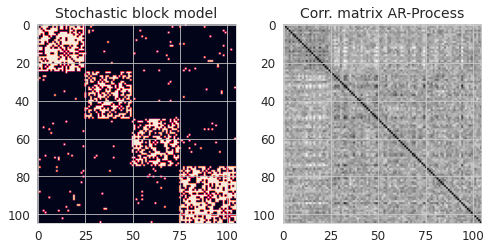

In [5]:
# Create adjacency
import scipy.stats as st
corr_ar, pvalue_ar = st.spearmanr(y_ar, axis=1, nan_policy='propagate')

fig, axs = plt.subplots(1, 2)
axs[0].imshow(A_sbm)
axs[0].set_title("Stochastic block model")
axs[1].imshow(corr_ar, cmap='Greys')
axs[1].set_title("Corr. matrix AR-Process")

## Generate gaussian random variables with covariance structure given by adjacency

/tmp/ipykernel_25626/379211077.py:7: RuntimeWarning: covariance is not positive-semidefinite.
  X_gauss = np.random.multivariate_normal(mean, cov, length)


Text(0, 0.5, 'x(t)')

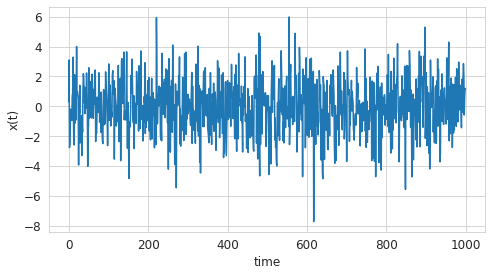

In [6]:
length = int(1e3)
A_sbm = nx.adjacency_matrix(G_sbm).todense()

mean = np.zeros(A_sbm.shape[0])
cov = 1.0 * A_sbm

X_gauss = np.random.multivariate_normal(mean, cov, length)

fig, ax = plt.subplots()
ax.plot(X_gauss[:,1])
ax.set_xlabel('time')
ax.set_ylabel('x(t)')

Text(0.5, 1.0, 'Corr. matrix Gauss-sample')

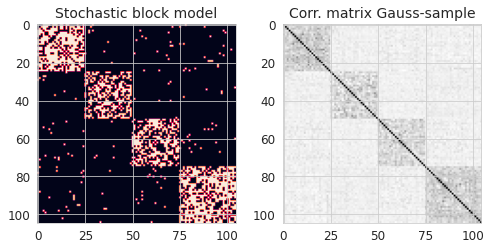

In [7]:
corr_gauss, pvalue_gauss = st.spearmanr(X_gauss, axis=0, nan_policy='propagate')

fig, axs = plt.subplots(1, 2)
axs[0].imshow(A_sbm)
axs[0].set_title("Stochastic block model")
axs[1].imshow(corr_gauss, cmap='Greys')
axs[1].set_title("Corr. matrix Gauss-sample")

Text(0.5, 1.0, 'Gauss sampled')

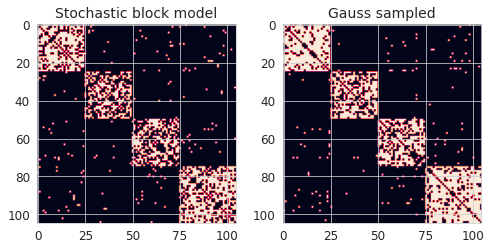

In [8]:
# Created adjacency matrix.
threshold = 0.11
A_gauss = np.where(np.abs(corr_gauss) >= threshold, 1, 0)
# set diagonal to zero
for i in range(len(A_gauss)):
    A_gauss[i, i] = 0
adjacency = A_gauss * A_gauss.transpose()

fig, axs = plt.subplots(1, 2)
axs[0].imshow(A_sbm)
axs[0].set_title("Stochastic block model")
axs[1].imshow(A_gauss)
axs[1].set_title("Gauss sampled")

Create Graph

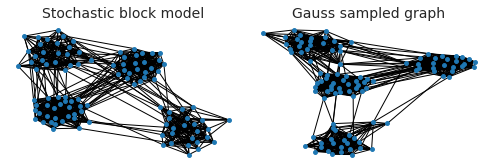

In [9]:
G_gauss = nx.Graph(A_gauss, undirected=True)

plt.figure(figsize=(7, 2.5))
ax = plt.subplot(121)
ax.set_title("Stochastic block model")
my_pos = nx.spring_layout(G_sbm, seed = 32)
nx.draw(G_sbm, my_pos, node_size=15)

ax = plt.subplot(122)
ax.set_title("Gauss sampled graph")
cnx_pos = nx.spring_layout(G_gauss, seed = 32)
nx.draw(G_gauss, cnx_pos, node_size=15)


Compute betweenness and network curvatures of the graph:

In [10]:
G = G_gauss

In [11]:
print("\n===== Compute Betweenness Centrality of the given graph G =====")
ebc = nx.edge_betweenness_centrality(G, weight="weight")
nbc = nx.betweenness_centrality(G, weight="weight")
print("\n===== Compute the Forman-Ricci curvature of the given graph G =====")
frc = FormanRicci(G, verbose="INFO")
frc.compute_ricci_curvature()
print("\n===== Compute the Ollivier-Ricci curvature of the given graph G =====")
orc = OllivierRicci(G, alpha=0.5, verbose="TRACE", proc=1, method="OTD")
orc.compute_ricci_curvature()

TRACE:Number of nodes: 105
TRACE:Number of edges: 1041
TRACE:Start to compute all pair shortest path.
TRACE:0.002967 secs for all pair by NetworKit.



===== Compute Betweenness Centrality of the given graph G =====

===== Compute the Forman-Ricci curvature of the given graph G =====
Forman curvature (augmented) computation done.

===== Compute the Ollivier-Ricci curvature of the given graph G =====


INFO:0.137210 secs for Ricci curvature computation.


### Plot graph with colored edges

Text(-0.05, 0.95, 'c.')

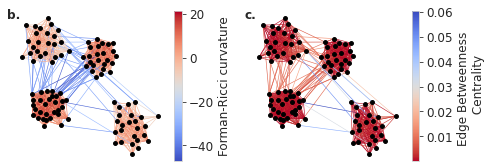

In [12]:
plt.figure(figsize=(7, 2.5))
# Froman curvature
ax = plt.subplot(121)
colors = [frc.G[u][v]['formanCurvature'] for u, v in orc.G.edges]
vmin = min(colors)
vmax = max(colors)
# vmin = -30
# vmax = 10

cmap = cm.coolwarm
nx.draw(G, pos=my_pos, edge_color=colors, edge_cmap=cmap, vmin=vmin,
        vmax=vmax, width=.6, node_size=15, node_color='k')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cb = plt.colorbar(sm, label='Forman-Ricci curvature')
cb.ax.tick_params(labelsize=12)
ax.text(-0.05, 0.95, f"b.", transform=ax.transAxes, weight='bold')

# Betweenness centrality
ax = plt.subplot(122)
colors = list(ebc.values())
vmin = min(colors)
vmax = max(colors)
# vmin = 0.04
# vmax = 0.05
cmap = cm.coolwarm_r
nx.draw(G, pos=my_pos, edge_color=colors, edge_cmap=cmap, vmin=vmin,
        vmax=vmax, width=.6, node_size=15, node_color='k')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cb = plt.colorbar(sm, label='Edge Betweenness \n Centrality')
cb.ax.tick_params(labelsize=12)
ax.text(-0.05, 0.95, f"c.", transform=ax.transAxes, weight='bold')

### Distribution of forman, ollivier and betweenness

Text(0.5, 0, 'Betweeness')

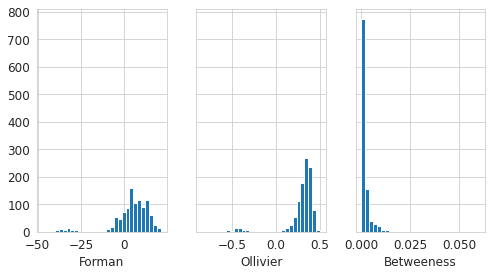

In [13]:
fig, axs = plt.subplots(1,3, sharey=True)
# forman
_ = axs[0].hist([frc.G[u][v]['formanCurvature'] for u,v in orc.G.edges],bins=30)
axs[0].set_xlabel('Forman')
_ = axs[1].hist([orc.G[u][v]['ricciCurvature'] for u,v in orc.G.edges],bins=30)
axs[1].set_xlabel('Ollivier')
_ = axs[2].hist(list(ebc.values()),bins=30)
axs[2].set_xlabel('Betweeness')

In [ ]:
da_gauss = xr.DataArray(data=np.zeros_like(Grid.grid['lon']),
                       dims=['time', 'points'],
                       coords=dict(
                           time=np.arange(length),
                           points=np.arange(0, num_points, 1),
                           lon=("points", feketeGrid.grid['lon']),
                           lat=("points", feketeGrid.grid['lat']))
                       )
idx_range = sput.get_locations_in_range(da_grid, lon_range=[-150, -130], lat_range=[-10,10])

In [ ]:
da_grid

In [ ]:
# Load dataset corresponding to the networks
from climnet.dataset import BaseDataset
ds = BaseDataset(load_nc=ds_gauss)

In [ ]:
# Plot edges
import climnet.plots as cplt
im = cplt.plot_edges(ds, edge_dic['el'][0::loc['link_step']],
                     ax=im['ax'],
                     significant_mask=True,
                     orientation='vertical',
                     projection='EqualEarth',
                     plt_grid=True,
                     lw=0.1,
                     alpha=0.6,
                     color=colors[j],
                     )